# Neural Networks

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
os.environ['PYTHONHASHSEED'] = str(0)

In [2]:
class FullyConnected(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 2 * in_features, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(2 * in_features),
            nn.Linear(2 * in_features, 4 * in_features, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(4 * in_features),
            nn.Linear(4 * in_features, 2 * in_features, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(2 * in_features),
            nn.Linear(2 * in_features, num_classes)
        )
    def forward(self, X):
        return self.model(X)

In [3]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [57]:
# Define hyperparam
hyperparam = {
    "batch_size": 64,
    "lr": 1e-3
}

In [58]:
# Prepare data

df = np.array(pd.read_csv("fetal_health.csv"), dtype=np.float32)
np.random.shuffle(df)
X = np.array(df[:, :-1])
y = np.array(df[:, -1], dtype=np.int64) - 1 # We subtract 1 to make classes 0,1,2 instead of 1,2,3
num_data = len(y)
num_train = int(np.floor(num_data * 0.6))
num_val = int(np.floor(num_data * 0.2))

train_X = X[:num_train]
train_y = y[:num_train]

val_X = X[num_train:num_train + num_val]
val_y = y[num_train:num_train + num_val]

test_X = X[num_train + num_val:]
test_y = y[num_train + num_val:]

train_dataset = TabularDataset(train_X, train_y)
val_dataset = TabularDataset(val_X, val_y)
test_dataset = TabularDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)

In [59]:
model = FullyConnected(train_X.shape[1], len(np.unique(y)))

In [60]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), hyperparam["lr"])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99) 
num_epochs = 100

In [61]:
def predict(model, dataloader):
    num_correct = 0
    num_total = 0
    with torch.no_grad():
        for i, data in enumerate(train_loader):
            # Unpack data
            batch_X, batch_y = data

            # Perform forward pass
            pred = model(batch_X)
            
            num_correct += (torch.argmax(out, dim=1) == batch_y).int().sum()
            num_total += len(batch_y)
    return num_correct / num_total
    

In [62]:
# Training loop

losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # Unpack data
        batch_X, batch_y = data
        
        # Zero previous grad
        optimizer.zero_grad()
        
        # Perform forward pass
        out = model(batch_X)
        loss = loss_criterion(out, batch_y)
        
        # Perform backward pass
        loss.backward()
        
        # Update learning rate
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            average_loss = running_loss / 10
            losses.append(average_loss)
            running_loss = 0.0
            
            with torch.no_grad():
                acc = torch.mean((torch.argmax(out, dim=1) == batch_y).float())
                train_accuracies.append(acc)
            print(f'[Epoch {epoch + 1}, Iteration {i + 1}] loss: {average_loss} train_accuracy: {acc}')
    with torch.no_grad():
        acc = predict(model, val_loader)
        val_accuracies.append(acc)
        print(f'[{epoch + 1}] val_accuracy: {acc}')

[Epoch 1, Iteration 10] loss: 1.059834885597229 train_accuracy: 0.671875
[1] val_accuracy: 0.5435855388641357
[Epoch 2, Iteration 10] loss: 0.7585169017314911 train_accuracy: 0.828125
[2] val_accuracy: 0.5674341917037964
[Epoch 3, Iteration 10] loss: 0.6851090073585511 train_accuracy: 0.84375
[3] val_accuracy: 0.5814144611358643
[Epoch 4, Iteration 10] loss: 0.5223474442958832 train_accuracy: 0.875
[4] val_accuracy: 0.5921052694320679
[Epoch 5, Iteration 10] loss: 0.46573631167411805 train_accuracy: 0.890625
[5] val_accuracy: 0.5912829041481018
[Epoch 6, Iteration 10] loss: 0.48082647323608396 train_accuracy: 0.90625
[6] val_accuracy: 0.6274670958518982
[Epoch 7, Iteration 10] loss: 0.3644257366657257 train_accuracy: 0.90625
[7] val_accuracy: 0.6398026347160339
[Epoch 8, Iteration 10] loss: 0.3512387752532959 train_accuracy: 0.875
[8] val_accuracy: 0.6143091917037964
[Epoch 9, Iteration 10] loss: 0.3478041499853134 train_accuracy: 0.890625
[9] val_accuracy: 0.625
[Epoch 10, Iteration 1

[Epoch 75, Iteration 10] loss: 0.10511273331940174 train_accuracy: 0.96875
[75] val_accuracy: 0.6414473652839661
[Epoch 76, Iteration 10] loss: 0.12150970734655857 train_accuracy: 0.96875
[76] val_accuracy: 0.6274670958518982
[Epoch 77, Iteration 10] loss: 0.07282554786652326 train_accuracy: 0.953125
[77] val_accuracy: 0.5929276347160339
[Epoch 78, Iteration 10] loss: 0.08916943855583667 train_accuracy: 0.9375
[78] val_accuracy: 0.5995065569877625
[Epoch 79, Iteration 10] loss: 0.09656791798770428 train_accuracy: 0.984375
[79] val_accuracy: 0.6488487124443054
[Epoch 80, Iteration 10] loss: 0.11117662638425826 train_accuracy: 0.953125
[80] val_accuracy: 0.6184210777282715
[Epoch 81, Iteration 10] loss: 0.10210685767233371 train_accuracy: 0.921875
[81] val_accuracy: 0.6011512875556946
[Epoch 82, Iteration 10] loss: 0.103883907943964 train_accuracy: 0.984375
[82] val_accuracy: 0.6184210777282715
[Epoch 83, Iteration 10] loss: 0.10845344327390194 train_accuracy: 0.96875
[83] val_accuracy: 

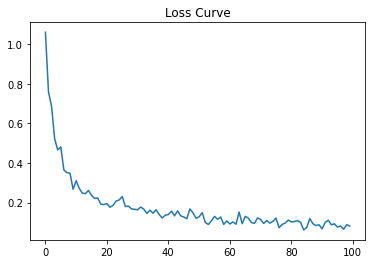

In [63]:
plt.plot(losses)
plt.title("Loss Curve")
plt.show()

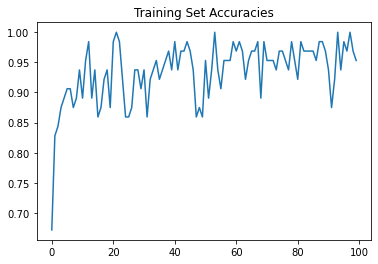

In [64]:
plt.plot(train_accuracies)
plt.title("Training Set Accuracies")
plt.show()

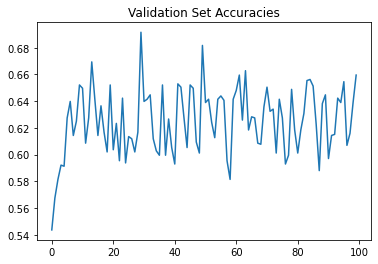

In [65]:
plt.plot(val_accuracies)
plt.title("Validation Set Accuracies")
plt.show()